# Smoothing

The most common operation performed on a time series is the smoothing. Moving averages are a prime example of smoothing. The idea is to remove - smoothen - the inherent noise present in every time series. Even the trend in a non-stationary series can be considered a smooth (although not so much) version of the original series.

There are many levels and ways of smoothing a time series. We'll be using the examples from statsmodels' documentation to learn more about these smoothing techniques.

## Simple Exponential Smoothing (SES)

We'll use a very short time series to illustrate SES.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

data = [
    446.6565,
    454.4733,
    455.663,
    423.6322,
    456.2713,
    440.5881,
    425.3325,
    485.1494,
    506.0482,
    526.792,
    514.2689,
    494.211,
]
index = pd.date_range(start="1996", end="2008", freq="A")
oildata = pd.Series(data, index)

Simple exponential smoothing (SES) is the most basic type of smoothing, it's pretty much an exponentially weighted moving average. We can use Pandas to compute the EWMA, provided we give it the smoothing factor alpha.

$$
\Large
l_t = \alpha y_t + (1-\alpha) l_{t-1}
$$

If you squint a little, it looks like an auto-regressive model, doesn't it? The difference is, there's a multiplier for the added innovation.

In [ ]:
alpha = 0.2
levels = [446.6565]
for y in oildata.values:
    new_lvl = alpha*y + (1-alpha)*levels[-1]
    levels.append(new_lvl)
levels = np.array(levels)
levels

array([446.6565    , 446.6565    , 448.21986   , 449.708488  ,
       444.4932304 , 446.84884432, 445.59669546, 441.54385636,
       450.26496509, 461.42161207, 474.49568966, 482.45033173,
       484.80246538])

However, SES differs a bit from Pandas' EWMA since SES duplicates the first data point as initial level.

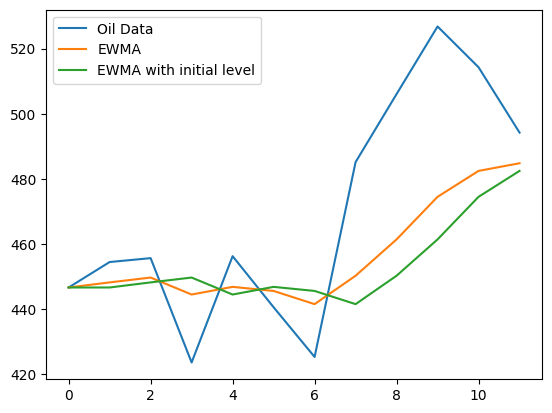

In [ ]:
ewma02 = oildata.to_frame().ewm(alpha=.2, adjust=False).mean()
ewma02_initial = np.concatenate([oildata[0].reshape(1,), ewma02[:-1].values.squeeze()])
plt.plot(oildata.values, label='Oil Data')
plt.plot(ewma02.values, label='EWMA')
plt.plot(ewma02_initial, label='EWMA with initial level')
plt.legend()

See the difference? The line in green, the EWMA with the initial level, has two identical values at the start.

Let's use statsmodels' simple exponential smoothing with the same smoothing level (alpha). We also set optimized to false in this case, so it won't compute the optimal initial level and it will default to the first value as we did manually.

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


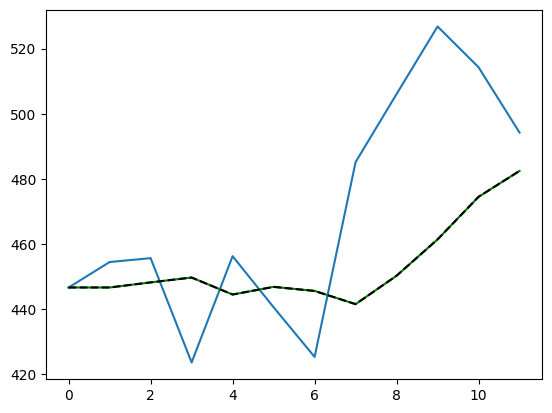

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit1 = SimpleExpSmoothing(oildata, initialization_method=None).fit(
    smoothing_level=0.2, optimized=False
)

plt.plot(oildata.values, label='Oil Data')
plt.plot(ewma02_initial, c='g', label='EWMA with initial level')
plt.plot(fit1.fittedvalues.values, linestyle='--', c='k', label='Fitted Values')

In [ ]:
print(((oildata.values-ewma02_initial)**2).sum())

12391.754880859531


The initial level was set to be exactly the same value as the first real observation for the sake of simplicity.

However, we can ask SES to estimate the initial level:

In [ ]:
ses2 = SimpleExpSmoothing(oildata, initialization_method='estimated')
fit2 = ses2.fit(smoothing_level=0.2, optimized=False)
fit2.fittedvalues.values

array([421.4242    , 426.47066   , 432.071188  , 436.7895504 ,
       434.15808032, 438.58072426, 438.9821994 , 436.25225952,
       446.03168762, 458.0349901 , 471.78639208, 480.28289366])

Where does it come from? Let's take a look under the hood:

In [ ]:
from statsmodels.tsa.exponential_smoothing.initialization import _initialization_heuristic

# from _initialization_heuristic
# it really only uses the first 10 elements to find trend and level
endog = oildata.values
exog = np.c_[np.ones(10), np.arange(10) + 1]
if endog.ndim == 1:
    endog = np.atleast_2d(endog).T
beta = np.squeeze(np.linalg.pinv(exog).dot(endog[:10]))
beta

array([421.4242    ,   7.38844545])

There it is, the estimated initial level and the slope coefficient. It only uses the first 10 elements in the time series to make the estimate which, by the way, is just linear regression:

In [ ]:
from sklearn.linear_model import LinearRegression

lin0 = LinearRegression()
lin0.fit(np.arange(10).reshape(-1, 1)+1, endog[:10])
lin0.intercept_, lin0.coef_

(array([421.4242]), array([[7.38844545]]))

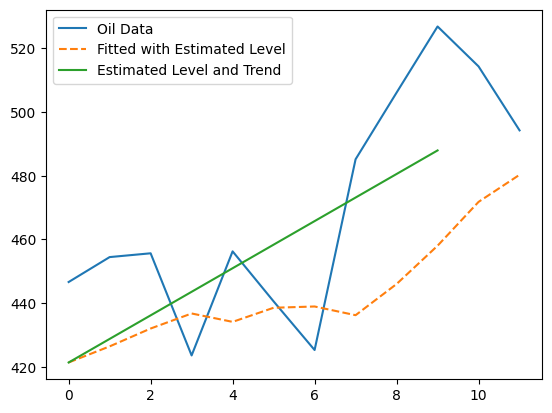

In [ ]:
plt.plot(oildata.values, label='Oil Data')
plt.plot(fit2.fittedvalues.values, linestyle='--', label='Fitted with Estimated Level')
plt.plot(lin0.predict(np.arange(10).reshape(-1, 1)), label='Estimated Level and Trend')
plt.legend()

What about the sum of squared errors? How good is the fit?

In [ ]:
print(((oildata.values-fit2.fittedvalues.values)**2).sum())

15549.038750929201


We can actually do better if we choose a different smoothing factor.

"_Where did the smoothing factor (0.2) come from_" you ask? It was randomly chosen to illustrate the smoothing process.

In practice, however, we'll use an optimized factor and initial level such that the SSE between the smoothed and raw values is minimized.

In [ ]:
ses3 = SimpleExpSmoothing(oildata, initialization_method='estimated')
fit3 = ses3.fit(optimized=True)

fit3.params, fit3.fittedvalues

({'smoothing_level': 0.8920002400624609,
  'smoothing_trend': nan,
  'smoothing_seasonal': nan,
  'damping_trend': nan,
  'initial_level': 447.47856232093693,
  'initial_trend': nan,
  'initial_seasons': array([], dtype=float64),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False},
 1996-12-31    447.478562
 1997-12-31    446.745283
 1998-12-31    453.638676
 1999-12-31    455.444373
 2000-12-31    427.067907
 2001-12-31    453.117341
 2002-12-31    441.941255
 2003-12-31    427.126242
 2004-12-31    478.882913
 2005-12-31    503.114356
 2006-12-31    524.234820
 2007-12-31    515.345217
 Freq: A-DEC, dtype: float64)

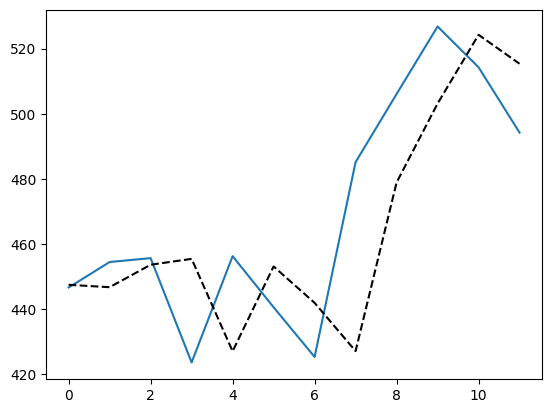

In [ ]:
plt.plot(oildata.values, label='Oil Data')
plt.plot(fit3.fittedvalues.values, linestyle='--', c='k', label='Optimized Fitted Values')

The smoothed series looks like a lagged version of the raw values.

What is the SSE now?

In [ ]:
print(((oildata.values-fit3.fittedvalues.values)**2).sum())

7573.4263617929055


Much better, right?

What about the forecast?

Simple exponential smoothing has a “flat” forecast function. That is, all forecasts take the same value, equal to the last level component. Remember that these forecasts will only be suitable if the time series has no trend or seasonal component.

In [ ]:
fit3.forecast(7)

2008-12-31    496.49349
2009-12-31    496.49349
2010-12-31    496.49349
2011-12-31    496.49349
2012-12-31    496.49349
2013-12-31    496.49349
2014-12-31    496.49349
Freq: A-DEC, dtype: float64

![](https://i.imgflip.com/8ctdiw.jpg)

### Error, Trend, Seasonal (ETS) Models

Let's try something different now. Let's assume we have already computed yesterday's smoothed value for our series. It's yesterday's level (l) if you will. Well, that's the naive forecast for today's value (y^): yesterday's level. So, let's start with that.

Then, we actually observe today's value (y). The difference, as you know, it's the error (epsilon).

We need to smooth the new value as well, but what if simply add the error term (multiplied by the smoothing factor alpha) to our naive forecast? That could be today's new level.

$$
\Large
\hat{y_t} = l_{t-1}
\\
\Large
\epsilon_t = y_t - \hat{y_t}
\\
\Large
l_t = \hat{y_t} + \alpha \epsilon_t
$$

If we replace y^ in the second and third equations, we get:
$$
\Large
\epsilon_t = y_t - l_{t-1}
\\
\Large
l_t = l_{t-1}+\alpha\epsilon_t
$$

Then, if we rearrange the first equation:
$$
\Large
 y_t = l_{t-1} + \epsilon_t
\\
\Large
l_t = l_{t-1}+\alpha\epsilon_t
$$

The first equation is called **measurement** (or observation) equation, and the second one is called **state** (or transition) equation.

If we make further substitutions, and work the expression, this is what we get:

$$
\Large
l_t = l_{t-1} + \alpha (y_t - l_{t-1})
\\
\Large
l_t = l_{t-1} + \alpha y_t - \alpha l_{t-1}
\\
\Large
l_t = \alpha y_t + l_{t-1} - \alpha l_{t-1}
\\
\Large
l_t = \alpha y_t + (1-\alpha) l_{t-1}
$$

Surprise, surprise, we're back to the EWMA or SES expression!

Let's "prove it" using code and a smoothing factor of 0.2:

In [ ]:
alpha = 0.2
levels = [446.6565]
for y in oildata.values:
    fcast = levels[-1]
    error = y - fcast
    new_lvl = fcast + alpha*error
    levels.append(new_lvl)
levels = np.array(levels)
levels, fit1.fittedvalues.values

(array([446.6565    , 446.6565    , 448.21986   , 449.708488  ,
        444.4932304 , 446.84884432, 445.59669546, 441.54385636,
        450.26496509, 461.42161207, 474.49568966, 482.45033173,
        484.80246538]),
 array([446.6565    , 446.6565    , 448.21986   , 449.708488  ,
        444.4932304 , 446.84884432, 445.59669546, 441.54385636,
        450.26496509, 461.42161207, 474.49568966, 482.45033173]))

As expected, the values match. We got the same results as the fitted values using statsmodels' SES.

You may be thinking "_Why bother? They are the same, so what?_"

But there's one clear advantage to the ETS formulation. After we forecast a new value (y hat), we can simply draw a whole lot of samples from a Gaussian distribution to play the role of the error term (after all, it's supposed to be noise!), and simply multiply them by the known smoothing factor.

We're able to simulate thousands of scenarios and compute probability distributions for our forecast. How cool is that?

Let's fit an ETS model to see how it goes:

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(oildata)
fit = model.fit(maxiter=10000)
fit.fittedvalues

1996-12-31    447.478704
1997-12-31    446.745300
1998-12-31    453.638658
1999-12-31    455.444366
2000-12-31    427.067990
2001-12-31    453.117273
2002-12-31    441.941280
2003-12-31    427.126288
2004-12-31    478.882766
2005-12-31    503.114269
2006-12-31    524.234749
2007-12-31    515.345235
Freq: A-DEC, dtype: float64

We can check the fitted parameters and see that they indeed match those of the last SES model we tried:

In [ ]:
fit.params, fit3.params

(0      0.891998
 1    447.478704
 dtype: float64,
 {'smoothing_level': 0.8920002400624609,
  'smoothing_trend': nan,
  'smoothing_seasonal': nan,
  'damping_trend': nan,
  'initial_level': 447.47856232093693,
  'initial_trend': nan,
  'initial_seasons': array([], dtype=float64),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False})

What about the forecast?

In [ ]:
pred = fit.get_prediction(start="2008", end="2015")
pred.predicted_mean

2008-12-31    496.493548
2009-12-31    496.493548
2010-12-31    496.493548
2011-12-31    496.493548
2012-12-31    496.493548
2013-12-31    496.493548
2014-12-31    496.493548
2015-12-31    496.493548
Freq: A-DEC, dtype: float64

![](https://i.imgflip.com/8cwgxj.jpg)

Now we also have probability intervals!

In [ ]:
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
2008-12-31,496.493548,447.255177,545.731918
2009-12-31,496.493548,430.513033,562.474062
2010-12-31,496.493548,417.231707,575.755389
2011-12-31,496.493548,405.876493,587.110602
2012-12-31,496.493548,395.793688,597.193407
2013-12-31,496.493548,386.632395,606.354700
2014-12-31,496.493548,378.178358,614.808737
2015-12-31,496.493548,370.289367,622.697728


And we can also generate simulated scenarios!

In [ ]:
simulated = fit.simulate(anchor="end", nsimulations=8, repetitions=100)
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2008-12-31,468.692315,526.960550,509.378285,505.784528,492.545471,460.693382,492.027363,498.509359,527.402715,503.517227,...,458.565478,488.010867,500.670626,485.225506,512.751008,518.624803,451.594227,485.413248,500.199971,447.085640
2009-12-31,485.163898,506.005058,507.202521,536.045466,505.564752,434.207447,481.434711,532.177430,522.874238,515.101215,...,469.210820,502.900208,503.423045,530.388887,511.612734,464.147204,477.918950,541.935204,505.398700,433.955352
2010-12-31,461.729510,549.265460,459.577083,543.318717,509.267892,450.689437,421.038434,534.490353,474.265439,544.222027,...,453.789784,472.976098,507.213356,561.505971,546.079314,478.312329,498.890987,560.377560,512.999240,460.524798
2011-12-31,453.099441,488.666268,442.848712,544.209491,542.311322,442.469089,388.378220,566.709351,443.082446,535.964370,...,465.611964,518.132509,526.690551,576.988361,536.051458,477.036613,453.639357,539.502076,506.512049,469.171142
2012-12-31,427.556577,475.954069,496.486904,549.442381,548.116161,426.184784,397.561265,604.544957,440.859843,483.293387,...,399.264461,510.589850,579.917054,578.942444,521.969227,491.244391,474.373319,558.344773,533.088486,450.000762
2013-12-31,439.972374,459.765985,480.555112,529.441340,527.738014,415.320926,428.388966,580.305592,455.241882,541.382057,...,407.996377,510.899308,633.373358,594.842946,541.783521,464.706926,517.620708,578.157542,508.665620,498.235203
2014-12-31,484.748996,447.410485,461.846156,536.191503,486.457939,421.302986,448.728838,571.434216,488.042033,502.603091,...,377.361489,536.921666,625.857350,575.700714,520.888967,471.829665,537.372588,580.197709,512.781926,516.961552
2015-12-31,481.071884,530.890430,435.143046,488.467060,467.097388,422.849749,489.150342,563.048989,459.372135,511.292067,...,397.777372,545.685666,529.748017,593.079584,588.421205,499.697221,545.602611,584.911992,548.679463,515.406326


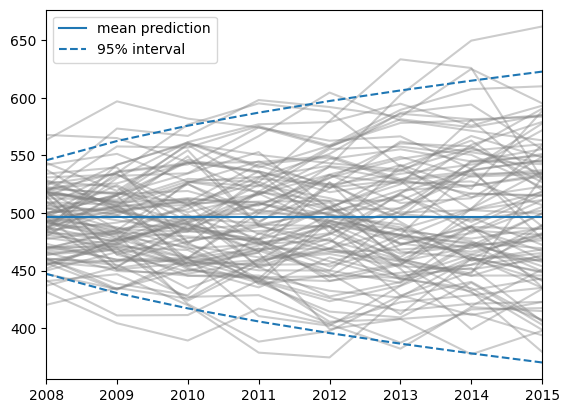

In [ ]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.4)
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
#pred.endog.plot(label="data")
plt.legend()

Not so boring anymore, huh?

## Double Exponential Smoothing / Holt

We applied smoothing to the series without any distinction to its components. We kinda fitted a "trend" to determine some initial level, but we did not have a proper trend component.

Now it's time to address that. Let's use yet another series from statsmodels' documentation:

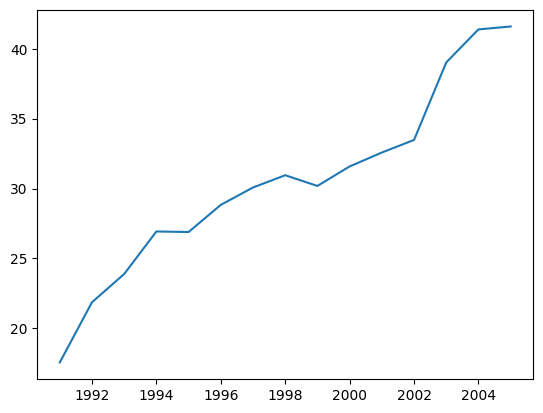

In [ ]:
data = [
    17.5534,
    21.86,
    23.8866,
    26.9293,
    26.8885,
    28.8314,
    30.0751,
    30.9535,
    30.1857,
    31.5797,
    32.5776,
    33.4774,
    39.0216,
    41.3864,
    41.5966,
]
index = pd.date_range(start="1990", end="2005", freq="A")
air = pd.Series(data, index)
plt.plot(air)

Let's bring back the original equation for SES:

$$
\Large
l_t = \alpha y_t + (1-\alpha) l_{t-1}
$$

But, now, instead of using just the previous level, we're using the previous level and - guess what - the previous trend (which we'll call `b`).

$$
\Large
l_t = \alpha y_t + (1-\alpha) (l_{t-1} + \color{green}{b_{t-1}})
$$

Next, we have to actually define an expression for the trend and we're following the same principle as before:

$$
\Large
b_t = \beta \color{red}{?_t} + (1-\beta) b_{t-1}
$$

For SES, the new observation (yt) was use to update the level. What should we use to update the trend? Well, what IS a trend anyway? A trend is a change in the level, so let's use that:

$$
\Large
b_t = \beta \color{red}{(l_t - l_{t-1})} + (1-\beta) b_{t-1}
$$

There we go, we have a smoothed trend now!

In [ ]:
holt1 = Holt(air, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
holt1.params

{'smoothing_level': 0.8,
 'smoothing_trend': 0.2,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 19.16660666666666,
 'initial_trend': 1.4014024242424257,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

We can code it ourselves to better understand it (we're using the estimated level and trend, though):

In [ ]:
alpha = holt1.params['smoothing_level']
beta = holt1.params['smoothing_trend']
levels = [holt1.params['initial_level']]
trends = [holt1.params['initial_trend']]
for y in air.values:
    new_lvl = alpha*y + (1-alpha)*(levels[-1]+trends[-1])
    new_trd = beta*(new_lvl-levels[-1]) + (1-beta)*trends[-1]
    levels.append(new_lvl)
    trends.append(new_trd)
levels = np.array(levels)
trends = np.array(trends)

trends[1:], levels[1:]

(array([0.91906497, 1.36460308, 1.55963021, 1.8359268 , 1.59090983,
        1.59822487, 1.54296389, 1.42558148, 1.05116396, 1.03113422,
        1.0218108 , 1.00042439, 1.7231512 , 1.97036037, 1.73817655]),
 array([18.15632182, 21.30307736, 23.64281609, 26.58392926, 27.19477121,
        28.82225621, 30.14417622, 31.10022802, 30.6537219 , 31.60473717,
        32.58925428, 33.50413302, 38.11819148, 41.07738854, 41.88682978]))

These values should match those produced by the fitted model, and they do:

In [ ]:
holt1.trend, holt1.level

(1990-12-31    0.919065
 1991-12-31    1.364603
 1992-12-31    1.559630
 1993-12-31    1.835927
 1994-12-31    1.590910
 1995-12-31    1.598225
 1996-12-31    1.542964
 1997-12-31    1.425581
 1998-12-31    1.051164
 1999-12-31    1.031134
 2000-12-31    1.021811
 2001-12-31    1.000424
 2002-12-31    1.723151
 2003-12-31    1.970360
 2004-12-31    1.738177
 Freq: A-DEC, dtype: float64,
 1990-12-31    18.156322
 1991-12-31    21.303077
 1992-12-31    23.642816
 1993-12-31    26.583929
 1994-12-31    27.194771
 1995-12-31    28.822256
 1996-12-31    30.144176
 1997-12-31    31.100228
 1998-12-31    30.653722
 1999-12-31    31.604737
 2000-12-31    32.589254
 2001-12-31    33.504133
 2002-12-31    38.118191
 2003-12-31    41.077389
 2004-12-31    41.886830
 Freq: A-DEC, dtype: float64)

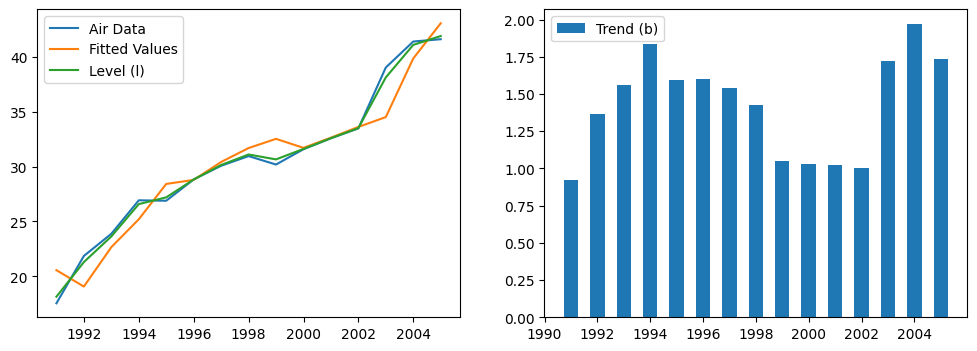

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(air, label='Air Data')
axs[0].plot(holt1.fittedvalues, label='Fitted Values')
axs[0].plot(holt1.level, label='Level (l)')
axs[0].legend()
axs[1].bar(holt1.trend.index, holt1.trend, width=200, label='Trend (b)')
axs[1].legend()

That's pretty good, and we even used kinda random smoothing factors!

What about the forecast?

In [ ]:
fcast1 = holt1.forecast(5)
fcast1

2005-12-31    43.625006
2006-12-31    45.363183
2007-12-31    47.101359
2008-12-31    48.839536
2009-12-31    50.577713
Freq: A-DEC, dtype: float64

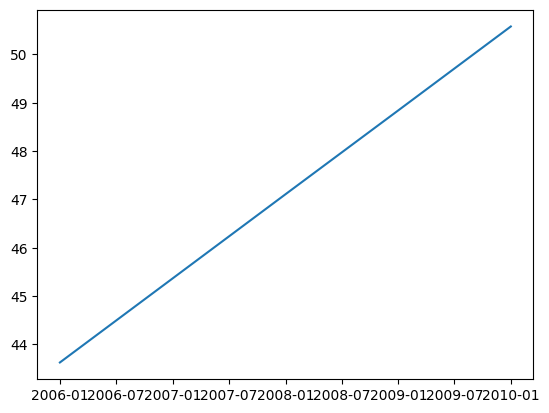

In [ ]:
plt.plot(fcast1)

No surprise, it's a linear trend, and its slope is exactly the last value of the fitted trend (b):

In [ ]:
fcast1.diff(), holt1.trend[-1], holt1.level[-1]

(2005-12-31         NaN
 2006-12-31    1.738177
 2007-12-31    1.738177
 2008-12-31    1.738177
 2009-12-31    1.738177
 Freq: A-DEC, dtype: float64,
 1.7381765468726016,
 41.88682978170021)

For each step `h` ahead, the forecast is given by:

$$
\Large
\hat{y_{t+h}} = l_t + h b_t
$$

In our case, it would be:

$$
\Large
\hat{y_{t+h}} = 41.88 + 1.73 h
$$

But, is it reasonable to expect a linear trend going up to infinity?

### Damped Trend

One way to handle this issue is to actually damp the trend.

So, we'll start with the DES equations below:

$$
\Large
l_t = \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1})
\\
\Large
b_t = \beta (l_t - l_{t-1}) + (1-\beta) b_{t-1}
$$

And then we'll add a multiplying factor to the previous trend:

$$
\Large
l_t = \alpha y_t + (1-\alpha) (l_{t-1} + \color{green}{\phi b_{t-1}})
\\
\Large
b_t = \beta (l_t - l_{t-1}) + (1-\beta) \color{green}{\phi b_{t-1}}
$$

That's it, the trend is dampened now!

Let's add damping to our DES model:

In [ ]:
holt2 = Holt(air, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2)
holt2.params

{'smoothing_level': 0.8,
 'smoothing_trend': 0.2,
 'smoothing_seasonal': nan,
 'damping_trend': 0.8779425914338764,
 'initial_level': 14.394516494782874,
 'initial_trend': 3.929600029893274,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The fitted model used a multiplying factor phi of ~0.878.

We can also implement the loop ourselves once again:

In [ ]:
phi = holt2.params['damping_trend']
phi = 1 if np.isnan(phi) else phi
alpha = holt2.params['smoothing_level']
beta = holt2.params['smoothing_trend']
levels = [holt2.params['initial_level']]
trends = [holt2.params['initial_trend']]
for y in air.values:
    dampened_trend = phi*trends[-1]
    new_lvl = alpha*y + (1-alpha)*(levels[-1]+dampened_trend)
    new_trd = beta*(new_lvl-levels[-1]) + (1-beta)*dampened_trend
    levels.append(new_lvl)
    trends.append(new_trd)
levels = np.array(levels)
trends = np.array(trends)

levels[1:], trends[1:]

(array([17.61161595, 21.60791948, 23.99092909, 26.81867571, 27.30889705,
        28.84919071, 30.11037233, 31.02614241, 30.55540374, 31.49991479,
        32.48307828, 33.3980577 , 38.01297031, 40.9553076 , 41.74275856]),
 array([3.40339048, 3.18964587, 2.71686269, 2.4737489 , 1.83549188,
        1.59722393, 1.37405306, 1.14822578, 0.71231332, 0.68919837,
        0.68069398, 0.66108407, 1.38729761, 1.56284159, 1.25515835]))

In [ ]:
holt2.level, holt2.trend

(1990-12-31    17.611616
 1991-12-31    21.607919
 1992-12-31    23.990929
 1993-12-31    26.818676
 1994-12-31    27.308897
 1995-12-31    28.849191
 1996-12-31    30.110372
 1997-12-31    31.026142
 1998-12-31    30.555404
 1999-12-31    31.499915
 2000-12-31    32.483078
 2001-12-31    33.398058
 2002-12-31    38.012970
 2003-12-31    40.955308
 2004-12-31    41.742759
 Freq: A-DEC, dtype: float64,
 1990-12-31    3.403390
 1991-12-31    3.189646
 1992-12-31    2.716863
 1993-12-31    2.473749
 1994-12-31    1.835492
 1995-12-31    1.597224
 1996-12-31    1.374053
 1997-12-31    1.148226
 1998-12-31    0.712313
 1999-12-31    0.689198
 2000-12-31    0.680694
 2001-12-31    0.661084
 2002-12-31    1.387298
 2003-12-31    1.562842
 2004-12-31    1.255158
 Freq: A-DEC, dtype: float64)

We got matching values, so it's all good. What about the forecast?

2005-12-31    42.844716
2006-12-31    43.812170
2007-12-31    44.661540
2008-12-31    45.407238
2009-12-31    46.061918
Freq: A-DEC, dtype: float64

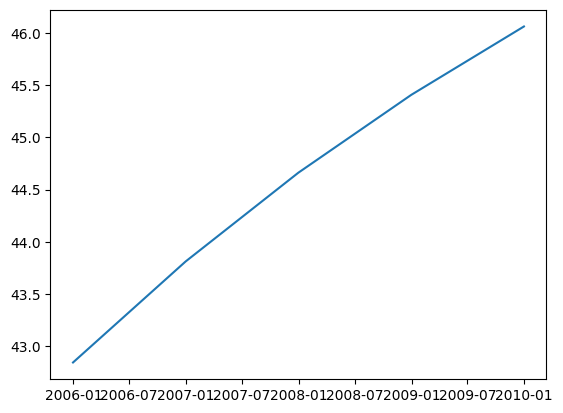

In [ ]:
fcast2 = holt2.forecast(5)
plt.plot(fcast2)
fcast2

See? The trend is tapering off.

The expression however it's a bit more involved now:

$$
\Large
\hat{y_{t+h}} = l_t + (\phi + \phi^2 + \cdots + \phi^h) b_t
$$

## Triple Exponential Smoothing (TES) / Holt-Winters

We already smoothed the level and the trend, so what's left to make it smoother? The seasonality, of course! Welcome to the Triple Exponential Smoothing (TES) a.k.a. Holt-Winders model.

These are the expressions for the DES model:

$$
\Large
l_t = \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1})
\\
\Large
b_t = \beta (l_t - l_{t-1}) + (1-\beta) b_{t-1}
$$

Now, consider this: where does seasonality manifest itself? It gets "mixed" in the level, right? In the previous notebook, we added seasonality to the basic AR process, and it made the level go up and down, seasonally.

So, first, we need to remove seasonality from the level (m is the periodicity, such as 12):

$$
\Large
l_t = \alpha (y_t \color{red}{-s_{t-m}}) + (1-\alpha) (l_{t-1} + b_{t-1})
$$

Then, of course, we need to develop an expression for seasonality:

$$
\Large
s_t = \gamma \color{red}{?_t} + (1-\gamma)s_{t-m}
$$

What is the "new" manifestation of seasonality? It's literally what's left after we take everything else out of the picture, that is, the previous level and the previous trend.

So, the whole thing looks like this:

$$
\Large
l_t = \alpha (y_t - S_{t-m}) + (1-\alpha) (l_{t-1} + b_{t-1})
\\
\Large
b_t = \beta (l_t - l_{t-1}) + (1-\beta) b_{t-1}
\\
\Large
s_t = \gamma (y_t - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m}
$$

Let's try yet another time series, one that's clearly seasonal, from statsmodels' documentation:

<Axes: >

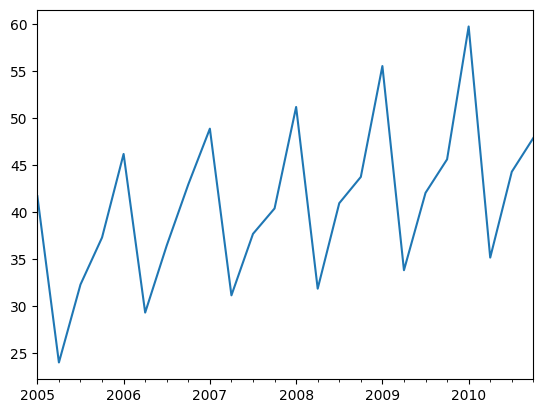

In [ ]:
import pandas as pd
data = [
    41.7275,
    24.0418,
    32.3281,
    37.3287,
    46.2132,
    29.3463,
    36.4829,
    42.9777,
    48.9015,
    31.1802,
    37.7179,
    40.4202,
    51.2069,
    31.8872,
    40.9783,
    43.7725,
    55.5586,
    33.8509,
    42.0764,
    45.6423,
    59.7668,
    35.1919,
    44.3197,
    47.9137,
]
index = pd.date_range(start="2005", end="2010-Q4", freq="QS-OCT")
aust = pd.Series(data, index)
aust.plot()

This is a quartely time series, so the seasonality is 4 quarters (one year). Let's fit a Holt Winters model on the short time series above:

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

seasonal_periods = 4

holt_winters = ExponentialSmoothing(
    aust,
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit(smoothing_level=0.2, smoothing_trend=0.5, smoothing_seasonal=0.9)

holt_winters.params

{'smoothing_level': 0.2,
 'smoothing_trend': 0.5,
 'smoothing_seasonal': 0.9,
 'damping_trend': nan,
 'initial_level': 31.832819753683747,
 'initial_trend': 1.0491348714972657,
 'initial_seasons': array([ 8.88755278, -9.94674257, -2.80790433,  0.78212876]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

We can also implement it ourselves to make sure we understand it thoroughly:

In [ ]:
alpha = holt_winters.params['smoothing_level']
beta = holt_winters.params['smoothing_trend']
gamma = holt_winters.params['smoothing_seasonal']
levels = [holt_winters.params['initial_level']]
trends = [holt_winters.params['initial_trend']]
seasons = holt_winters.params['initial_seasons'].tolist()

for i, y in enumerate(aust.values):
    new_lvl = alpha*(y-seasons[-seasonal_periods]) + (1-alpha)*(levels[-1]+trends[-1])
    new_trd = beta*(new_lvl-levels[-1]) + (1-beta)*trends[-1]
    new_sns = gamma*(y-levels[-1]-trends[-1]) + (1-gamma)*seasons[-seasonal_periods]
    levels.append(new_lvl)
    trends.append(new_trd)
    seasons.append(new_sns)
levels = np.array(levels)
trends = np.array(trends)
seasons = np.array(seasons)

Let's double check if our results match those of the fitted model:

In [ ]:
seasons[4:], holt_winters.season.values

(array([  8.84974612,  -9.8836928 ,  -2.67149463,   1.20038008,
          8.91732975,  -9.15871103,  -3.2410159 ,   2.08087961,
          6.89532851, -11.36741136,  -5.13946779,  -2.29516868,
          8.70746988, -11.11222251,  -2.62725493,  -0.85048789,
          9.90386143, -12.63842365,  -4.71322408,  -1.33193405,
         12.17709423, -13.25126   ,  -4.66193831,  -1.64538056]),
 array([  8.84974612,  -9.8836928 ,  -2.67149463,   1.20038008,
          8.91732975,  -9.15871103,  -3.2410159 ,   2.08087961,
          6.89532851, -11.36741136,  -5.13946779,  -2.29516868,
          8.70746988, -11.11222251,  -2.62725493,  -0.85048789,
          9.90386143, -12.63842365,  -4.71322408,  -1.33193405,
         12.17709423, -13.25126   ,  -4.66193831,  -1.64538056]))

In [ ]:
trends[1:], holt_winters.trend.values

(array([1.04493413, 1.05193966, 1.06709629, 1.11356866, 1.12107796,
        1.20163149, 1.13835134, 1.23618463, 1.01151782, 0.76610667,
        0.55516758, 0.06893999, 0.27028903, 0.29864335, 0.57777811,
        0.7382982 , 0.87123059, 0.70165269, 0.46987834, 0.41638432,
        0.66896574, 0.60087281, 0.60657123, 0.57174384]),
 array([1.04493413, 1.05193966, 1.06709629, 1.11356866, 1.12107796,
        1.20163149, 1.13835134, 1.23618463, 1.01151782, 0.76610667,
        0.55516758, 0.06893999, 0.27028903, 0.29864335, 0.57777811,
        0.7382982 , 0.87123059, 0.70165269, 0.46987834, 0.41638432,
        0.66896574, 0.60087281, 0.60657123, 0.57174384]))

In [ ]:
levels[1:], holt_winters.level.values

(array([32.87355314, 33.93249833, 35.01475126, 36.17479229, 37.30337954,
        38.58556456, 39.66063576, 40.99465367, 41.78150469, 42.30220021,
        42.64642869, 42.22914109, 42.70077916, 43.02777682, 43.88468969,
        44.78350798, 45.78767096, 46.31974574, 46.55784973, 46.92074003,
        47.84228719, 48.37506707, 48.98733672, 49.52425317]),
 array([32.87355314, 33.93249833, 35.01475126, 36.17479229, 37.30337954,
        38.58556456, 39.66063576, 40.99465367, 41.78150469, 42.30220021,
        42.64642869, 42.22914109, 42.70077916, 43.02777682, 43.88468969,
        44.78350798, 45.78767096, 46.31974574, 46.55784973, 46.92074003,
        47.84228719, 48.37506707, 48.98733672, 49.52425317]))

![](https://i.imgflip.com/8cx6nj.jpg)

In [ ]:
fcast_hw = holt_winters.forecast(5)
fcast_hw

2011-01-01    62.273091
2011-04-01    37.416481
2011-07-01    46.577546
2011-10-01    50.479294
2012-01-01    64.560067
Freq: QS-OCT, dtype: float64

Oh, this is more interesting, right?

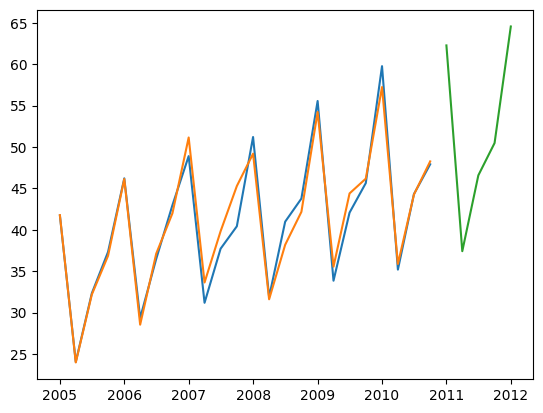

In [ ]:
plt.plot(aust, label='Data')
plt.plot(holt_winters.fittedvalues, label='Fitted Values')
plt.plot(fcast_hw, label='Forecast')

# Taxonomy

The models can be organized into a taxonomy according to the way their trend and season are modeled: None (N), Additive (A), Multiplicative (M), and damped (d).

The first letter in the tuple represents the trend, the second, the season. The models we discussed above are the following:

- (N,N) 	Simple exponential smoothing
- (A,N) 	Holt’s linear method
- (Ad,N) 	Additive damped trend method
- (A,A) 	Additive Holt-Winters’ method

We didn't talk about multiplicative models, but they follow the same general idea of additive models:

- (A,M) 	Multiplicative Holt-Winters’ method
- (Ad ,M) 	Holt-Winters’ damped method

Let's apply the first four models to the canonical dataset of time series: airline passengers!

First, we'll load the data:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
index = pd.date_range('1/1/1949', periods=144, freq='MS')
passengers = df['Passengers']
passengers.index = index
passengers

1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, Length: 144, dtype: int64

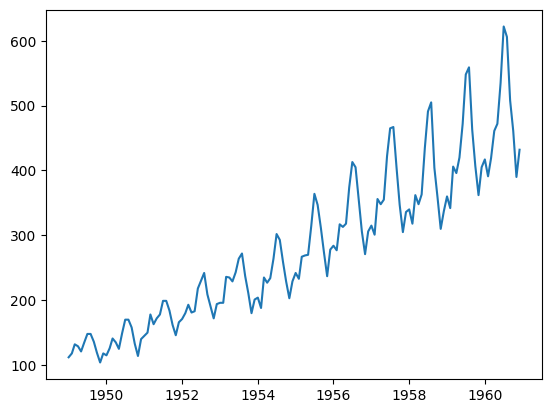

In [ ]:
plt.plot(passengers)

The dataset checks all the marks: it has a clear trend and a clear seasonality. Also it has a peculiar characteristic that makes it a bit harder to model, can you guess what it is?

For now, let's move forward and compare the models using the raw data without any transformations.

In [ ]:
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, Holt

# (N, N)
fit1 = SimpleExpSmoothing(passengers, initialization_method="estimated").fit(optimized=True)
# (A, N)
fit2 = Holt(passengers, initialization_method="estimated").fit(optimized=True)
# (Ad, N)
fit3 = Holt(passengers, damped_trend=True, initialization_method="estimated").fit(optimized=True)
# (A, A)
fit4 = ExponentialSmoothing(passengers, seasonal_periods=12, initialization_method="estimated", trend="add", seasonal="add",).fit(optimized=True)

params = [
    "smoothing_level",
    "smoothing_trend",
    "smoothing_seasonal",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\gamma$" , r"$\phi$", r"$l_0$", "$b_0$", "SSE"],
    columns=["SES", "Holt's", "Damped", "Holt-Winters"],
)
results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Damped"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Holt-Winters"] = [fit4.params[p] for p in params] + [fit4.sse]
results

,SES,Holt's,Damped,Holt-Winters
$\alpha$,1.000000,0.995000,0.995104,2.525499e-01
$\beta$,NaN,0.000100,0.000098,9.765464e-07
$\gamma$,NaN,NaN,NaN,7.474446e-01
$\phi$,NaN,NaN,0.990104,NaN
$l_0$,112.000000,118.466667,118.035540,1.184309e+02
$b_0$,NaN,2.060606,3.881495,2.594694e+00
SSE,162504.001479,162374.167750,162473.677466,2.156443e+04


Compare the SSEs at the bottom: clearly, the Holt-Winters model (triple exponential smoothing), which covers seasonality, is doing the best job.

Besides the parameters listed above, it also has the initial season values:

In [ ]:
fit4.params

{'smoothing_level': 0.25254989686499935,
 'smoothing_trend': 9.765463812739731e-07,
 'smoothing_seasonal': 0.7474446031813125,
 'damping_trend': nan,
 'initial_level': 118.43092695514434,
 'initial_trend': 2.59469363494243,
 'initial_seasons': array([ -9.06562263,  -3.43708014,   9.00565253,   3.81742261,
         -4.93283548,   9.17620296,  21.3830049 ,  18.84610688,
          4.61900836, -14.34042469, -28.91443539, -12.43815072]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

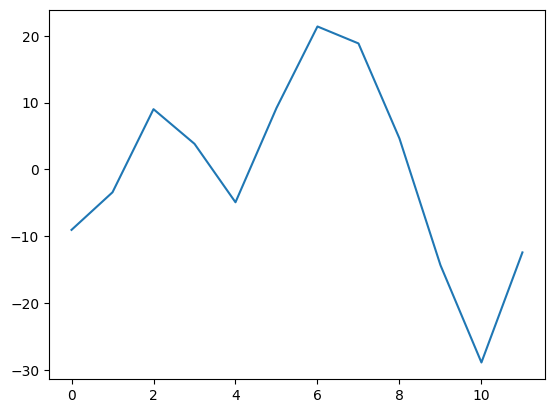

In [ ]:
plt.plot(fit4.params['initial_seasons'])

## DARTS

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.

In [ ]:
from darts.datasets import AirPassengersDataset
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics.metrics import smape

series = AirPassengersDataset().load()
ses = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=SeasonalityMode.NONE)
des = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.NONE)
tes = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.MULTIPLICATIVE)
ses.fit(series)
des.fit(series)
tes.fit(series)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=None, random_state=0, kwargs=None)

In [ ]:
tes.model

In [ ]:
tes.model.params

{'smoothing_level': 0.31858984848154576,
 'smoothing_trend': 1.8175187851378614e-11,
 'smoothing_seasonal': 0.6013507351426395,
 'damping_trend': nan,
 'initial_level': 107.39350730152889,
 'initial_trend': 2.525113559146981,
 'initial_seasons': array([1.01364572, 1.06601921, 1.17716653, 1.12293927, 1.04829851,
        1.14481232, 1.24486543, 1.22958253, 1.12102691, 0.9779187 ,
        0.86598899, 0.99183606]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<Axes: xlabel='Month'>

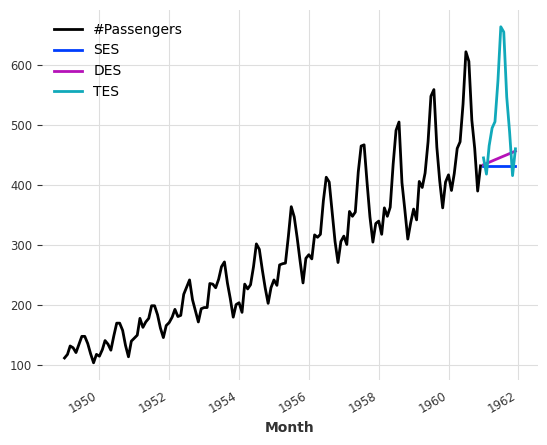

In [ ]:
series.plot()
ses.predict(12).plot(label='SES')
des.predict(12).plot(label='DES')
tes.predict(12).plot(label='TES')

<Axes: xlabel='time'>

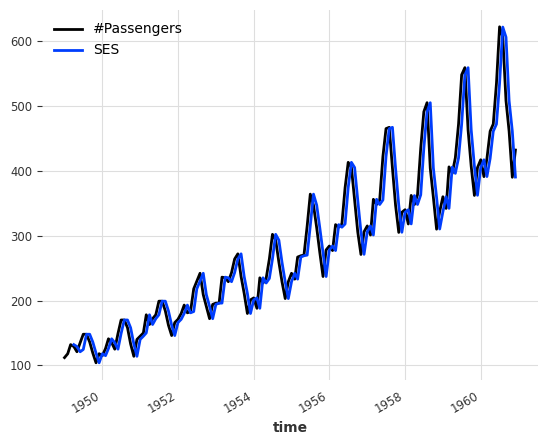

In [ ]:
series.plot()
ses_historical = ses.historical_forecasts(series)
ses_historical.plot(label='SES')

9.114533898263675

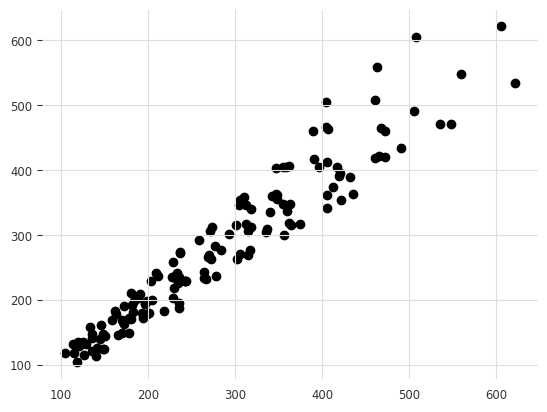

In [ ]:
plt.scatter(series.values()[3:], ses_historical.values())
smape(series, ses_historical)

<Axes: xlabel='time'>

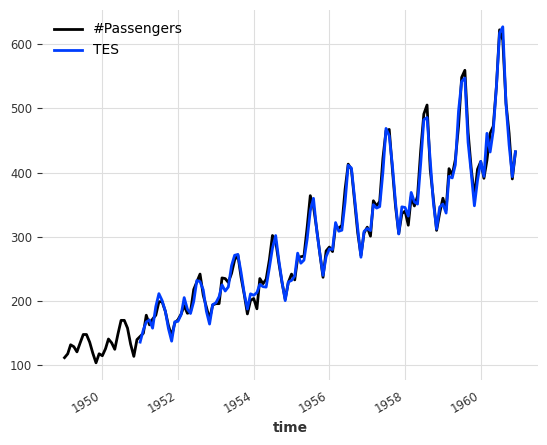

In [ ]:
series.plot()
tes_historical = tes.historical_forecasts(series)
tes_historical.plot(label='TES')

2.945072178048706

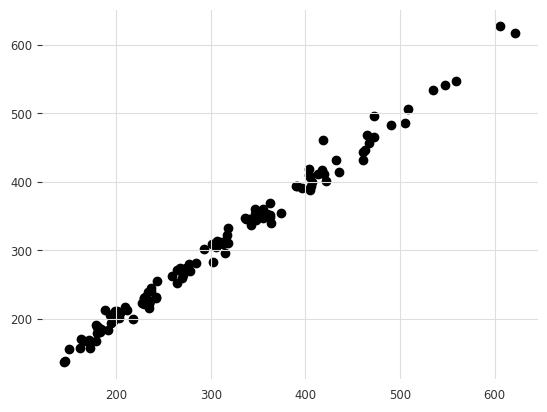

In [ ]:
plt.scatter(series.values()[24:], tes_historical.values())
smape(series, tes_historical)

## SkTime

In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 16.8 MB/s eta 0:00:00


In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon

y = load_airline()
model = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
model.fit(y)

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='add')

In [ ]:
model.get_fitted_params()

{'initial_level': 107.39350730152889,
 'initial_slope': None,
 'initial_seasons': array([1.01364572, 1.06601921, 1.17716653, 1.12293927, 1.04829851,
        1.14481232, 1.24486543, 1.22958253, 1.12102691, 0.9779187 ,
        0.86598899, 0.99183606]),
 'aic': 709.8917192933184,
 'bic': 757.4087320865344,
 'aicc': 715.3637192933184}

In [ ]:
model._forecaster

In [ ]:
model._forecaster.params

{'smoothing_level': 0.31858984848154576,
 'smoothing_trend': 1.8175187851378614e-11,
 'smoothing_seasonal': 0.6013507351426395,
 'damping_trend': nan,
 'initial_level': 107.39350730152889,
 'initial_trend': 2.525113559146981,
 'initial_seasons': array([1.01364572, 1.06601921, 1.17716653, 1.12293927, 1.04829851,
        1.14481232, 1.24486543, 1.22958253, 1.12102691, 0.9779187 ,
        0.86598899, 0.99183606]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
fh = ForecastingHorizon(y.index, is_relative=False)  # in-sample forecasting horizon
fittedvalues = model.predict(fh)
fittedvalues

Period
1949-01    111.418539
1949-02    120.062000
1949-03    134.827184
1949-04    130.592576
1949-05    124.085625
              ...    
1960-08    625.009023
1960-09    506.744600
1960-10    443.213024
1960-11    393.493719
1960-12    432.351048
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [ ]:
y_pred = model.predict(fh=range(1, 13))
y_pred

1961-01    445.242361
1961-02    418.225341
1961-03    465.309832
1961-04    494.951245
1961-05    505.475873
1961-06    573.312666
1961-07    663.596376
1961-08    654.904046
1961-09    546.760994
1961-10    488.446831
1961-11    415.723528
1961-12    460.377815
Freq: M, Name: Number of airline passengers, dtype: float64

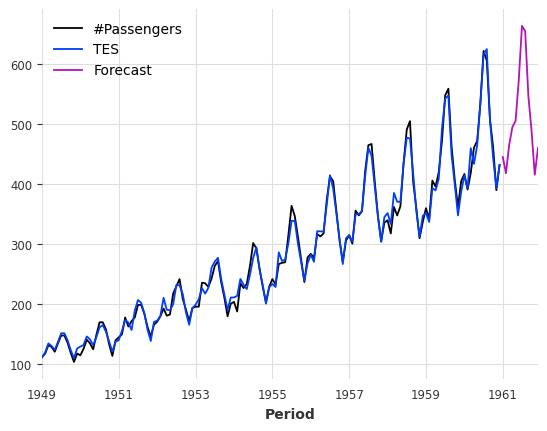

In [ ]:
ax = y.plot(label='#Passengers')
fittedvalues.plot(label='TES', ax=ax)
y_pred.plot(label='Forecast', ax=ax)
ax.legend()

# Box-Cox Transformation

Perhaps you noticed that the model's dictionaries had a particular key in them, `use_boxcox`, which was always set to false. As it turns out, the Box-Cox transformation is a fairly common and useful transformation that can be applied to the target variable we're trying to predict.

Its formulation goes like this:

$$
\Large
y'_t = \begin{cases}
\text{log}(y_t)\ \text{if}\ \lambda=0\\
\frac{(y_t^\lambda - 1)}{\lambda}\ \text{otherwise}
\end{cases}
$$

If, like me, you prefer it in code, here it is:

In [ ]:
def boxcox(y, lmbda):
    if lmbda == 0:
        return np.log(y)
    else:
        return (np.power(y, lmbda)-1)/lmbda

Let's see what happens to the variable once we transform it using Box-Cox using different lambdas:

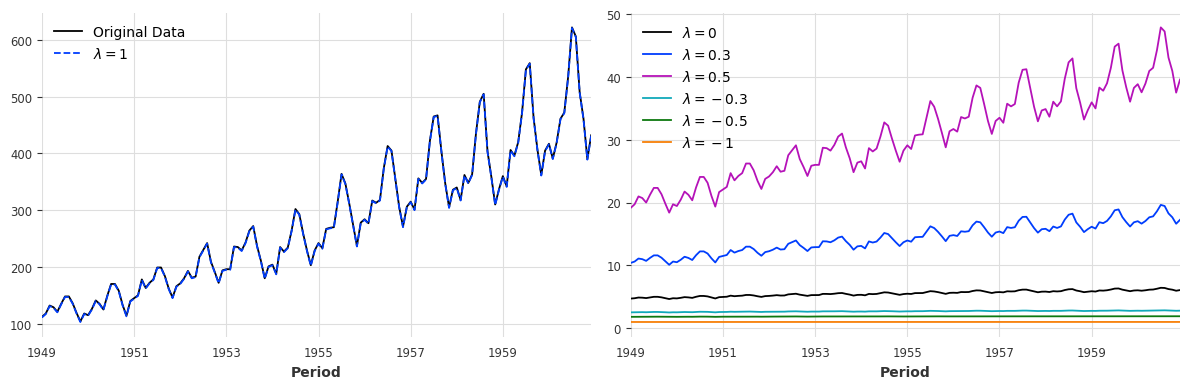

In [ ]:
from sktime.datasets import load_airline

y = load_airline()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.flatten()
y.plot(ax=axs[0], label='Original Data')
boxcox(y, 1).plot(ax=axs[0], label=r'$\lambda=1$', linestyle='--')
axs[0].legend()
boxcox(y, 0).plot(ax=axs[1], label=r'$\lambda=0$')
boxcox(y, .3).plot(ax=axs[1], label=r'$\lambda=0.3$')
boxcox(y, .5).plot(ax=axs[1], label=r'$\lambda=0.5$')
boxcox(y, -.3).plot(ax=axs[1], label=r'$\lambda=-0.3$')
boxcox(y, -.5).plot(ax=axs[1], label=r'$\lambda=-0.5$')
boxcox(y, -1).plot(ax=axs[1], label=r'$\lambda=-1$')
axs[1].legend()
fig.tight_layout()

So, here is what we have:
- lambda equals one is the same as the original series (minus one)
- lambda equals zero is a log transformation
- lambda equals minus one returns roughly a constant
- lambda between 0 and 1 is something in between the original values and the log transformation
- lambda between -1 and 0 is something in between a constant and the log transformation

Perhaps we can get a more clear picture if we plot their distributions instead:

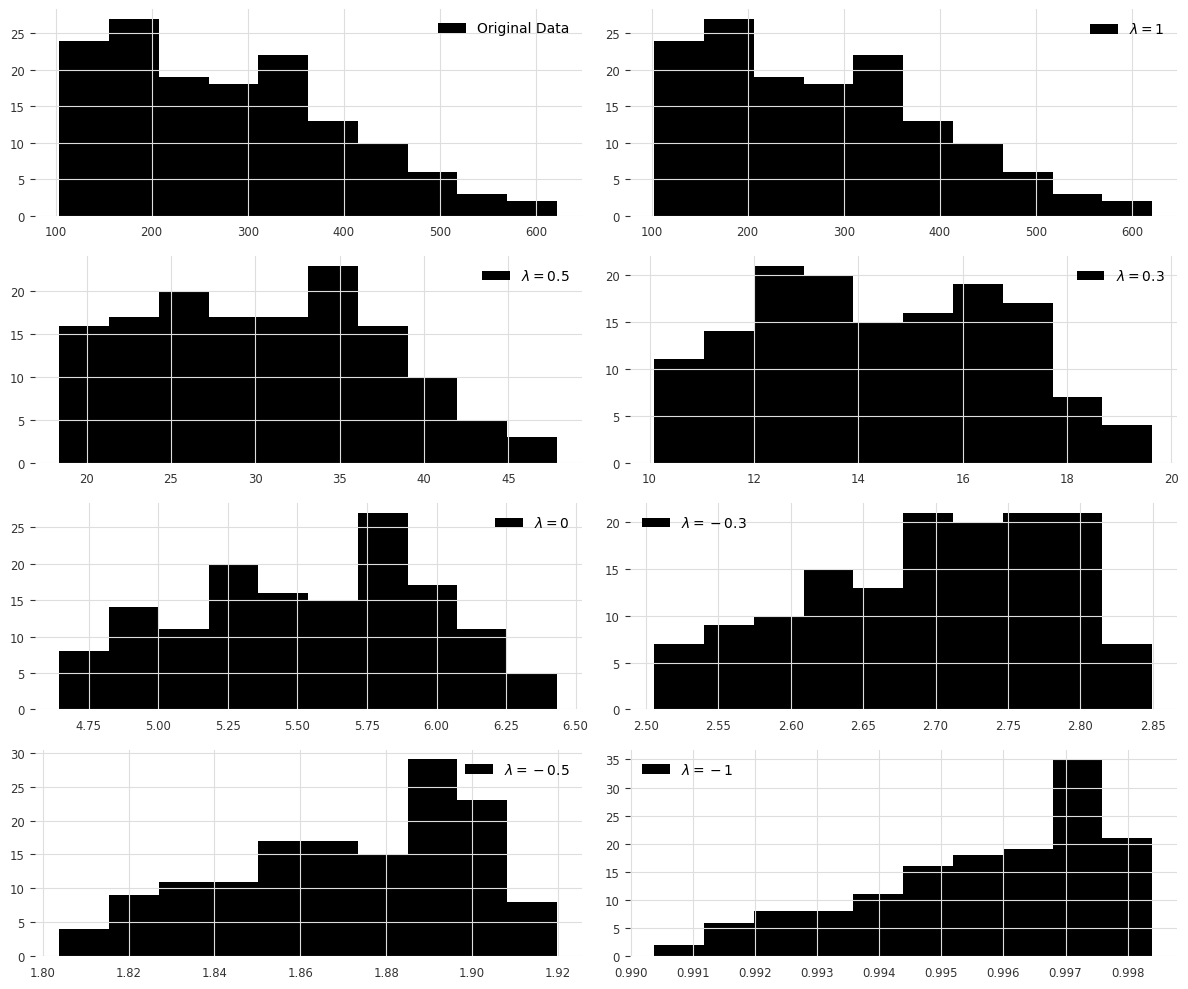

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
axs = axs.flatten()
y.hist(ax=axs[0], label='Original Data')
lmbdas = [1, .5, .3, 0, -.3, -.5, -1]
for i, ax in enumerate(axs):
    if i > 0:
        yt = boxcox(y, lmbdas[i-1])
        yt.hist(ax=ax, label=r'$\lambda='+str(lmbdas[i-1])+'$')
    ax.legend()
fig.tight_layout()

Intuitively, we may look more fondly at the distributions corresponding to lambda values of -0.3, 0, and 0.3 because they look more normal. Box-Cox transformations are indeed used to get a distribution more amenable to be modeled, and the normal distribution is, generally speaking, usually the first choice.

Still, wouldn't it be nice to have a more deterministic way of choosing a value for lambda?

Let's see how it's implement in scikit-time:

In [ ]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
transformer = BoxCoxTransformer(method='guerrero', sp=12)
y_hat = transformer.fit_transform(y)
transformer.lambda_

-0.2947236481659704

That's roughly -0.3, cool, but how exactly did it come to that particular value? It used a method proposed by Guerrero, which takens the seasonality into account to determine the optimal value for lambda.

The general idea is to stabilize variance across multiple seasons. So, here is the sequence of steps:
1. it breaks the series into seasonal chunks (that's what the `sp=12` argument is for)
2. applies the Box-Cox transformation to each season/chunk
3. computes the standard deviation for each transformed season/chunk
4. computes the coefficient of variation of those standard deviations (that is, the standard deviation of the standard deviations over the seasons divided by the mean of the standard deviations over the seasons).

### Step 1

In [ ]:
x = load_airline().values
sp = 12
num_obs = len(x)
# incomplete season to get rid of at the start
len_prefix = num_obs % sp
# removes incomplete season
x_trimmed = x[len_prefix:]
# reshapes to (n_seasons, season_length (sp))
x_mat = x_trimmed.reshape((-1, sp))
# average for each full season
x_mat.shape, x_mat

((12, 12),
 array([[112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118.],
        [115., 126., 141., 135., 125., 149., 170., 170., 158., 133., 114.,
         140.],
        [145., 150., 178., 163., 172., 178., 199., 199., 184., 162., 146.,
         166.],
        [171., 180., 193., 181., 183., 218., 230., 242., 209., 191., 172.,
         194.],
        [196., 196., 236., 235., 229., 243., 264., 272., 237., 211., 180.,
         201.],
        [204., 188., 235., 227., 234., 264., 302., 293., 259., 229., 203.,
         229.],
        [242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237.,
         278.],
        [284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271.,
         306.],
        [315., 301., 356., 348., 355., 422., 465., 467., 404., 347., 305.,
         336.],
        [340., 318., 362., 348., 363., 435., 491., 505., 404., 359., 310.,
         337.],
        [360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
    

### Step 2

In [ ]:
x_mat_bc_l1 = np.apply_along_axis(arr=x_mat, axis=1, func1d=lambda x: boxcox(x, -.3))
x_mat_bc_l2 = np.apply_along_axis(arr=x_mat, axis=1, func1d=lambda x: boxcox(x, .3))
x_mat_bc_l1[:2], x_mat_bc_l2[:2]

(array([[2.52402626, 2.53659788, 2.56295055, 2.55761897, 2.54257617,
         2.5681269 , 2.58894385, 2.58894385, 2.56981921, 2.53861239,
         2.50583192, 2.53659788],
        [2.53041866, 2.55212371, 2.57804459, 2.5681269 , 2.55025404,
         2.59044615, 2.61925794, 2.61925794, 2.60340265, 2.56469285,
         2.52831218, 2.57643015]]),
 array([[10.39583254, 10.61246393, 11.08951128, 10.99038124, 10.71789711,
         11.18707655, 11.59314174, 11.59314174, 11.21926082, 10.64781469,
         10.09396836, 10.61246393],
        [10.50513733, 10.88962405, 11.37774402, 11.18707655, 10.85566538,
         11.62332682, 12.22680385, 12.22680385, 11.88881226, 11.12220393,
         10.46892656, 11.34636585]]))

### Step 3

In [ ]:
std_bc_l1 = x_mat_bc_l1.std(axis=1, ddof=1)
std_bc_l2 = x_mat_bc_l2.std(axis=1, ddof=1)
std_bc_l1, std_bc_l2

(array([0.02543147, 0.03074784, 0.02320811, 0.02298802, 0.02522401,
        0.0278094 , 0.02634616, 0.02470345, 0.02569646, 0.02662706,
        0.02522678, 0.0244284 ]),
 array([0.46271088, 0.59611541, 0.50496906, 0.55595104, 0.64484295,
        0.74594153, 0.79053008, 0.81020046, 0.903153  , 0.9674288 ,
        0.9741878 , 1.00642043]))

### Step 4

In [ ]:
from scipy.stats import variation
cv_bc_l1 = std_bc_l1.std()/std_bc_l1.mean()
cv_bc_l2 = std_bc_l2.std()/std_bc_l2.mean()
cv_bc_l1, cv_bc_l2

(0.07773394595053039, 0.246544584787601)

The coefficient of variation for lambda -0.3 is lower than that for lambda 0.3 thus making the former the better choice of lambda. Now, we need to find the optimal lambda. However, transforming the original series over and over again for every lambda is wasteful. There's a clever shortcut implemented in Guerrero's algorithm. Let's take a quick look at it.

In the previous sequence of steps, we had to compute both the mean and standard deviation of the *transformed* series. But, as it turns out, we can easily approximate these values using the mean and standard deviation of the *original* series:

In [ ]:
x_mean = np.mean(x_mat, axis=1)

# [Guerrero, Eq.(5)] uses an unbiased estimation for
# the standard deviation
# std dev for each full season
x_std = np.std(x_mat, axis=1, ddof=1)

x_mean, x_std

(array([126.66666667, 139.66666667, 170.16666667, 197.        ,
        225.        , 238.91666667, 284.        , 328.25      ,
        368.41666667, 381.        , 428.33333333, 476.16666667]),
 array([13.72014666, 19.07084082, 18.43826719, 22.96637859, 28.46688666,
        34.92448564, 42.14045778, 47.86178016, 57.89089791, 64.53047201,
        69.83009684, 77.73712502]))

We can apply Box-Cox transformation to the mean of the original series...

In [ ]:
lmbda = -.3
((x_mean**lmbda)-1)/lmbda

array([2.55335948, 2.57588866, 2.61946783, 2.65014746, 2.67684957,
       2.68856335, 2.72114755, 2.74717179, 2.76712408, 2.77280025,
       2.79215029, 2.80906811])

... and it's roughly the same as the mean of the Box-Cox transformed series:

In [ ]:
x_mat_bc_l1.mean(axis=1)

array([2.55172049, 2.57339731, 2.61797188, 2.64856388, 2.67494823,
       2.68615727, 2.71883873, 2.74504427, 2.76473996, 2.77015189,
       2.78972927, 2.80671973])

The relationship between the standard deviations before and after transformation are not so straightforward, though:

$$
\Large
\sigma_{\text{BC}} = \sigma_{\text{original}} \mu_{\text{original}}^{\lambda-1}
$$

In [ ]:
x_std*x_mean**(lmbda-1)

array([0.02534532, 0.03102768, 0.02320509, 0.02389387, 0.0249174 ,
       0.02827546, 0.02725119, 0.02564028, 0.02669127, 0.02848147,
       0.02646831, 0.02567685])

Now, compare to the standard deviations of the transformed chunks:

In [ ]:
std_bc_l1

array([0.02543147, 0.03074784, 0.02320811, 0.02298802, 0.02522401,
       0.0278094 , 0.02634616, 0.02470345, 0.02569646, 0.02662706,
       0.02522678, 0.0244284 ])

It's not as close as the mean, but it's a good enough approximation for the optimization problem. Since we're interested in minimizing the coefficient of variation of the standard deviations of the transformed seasons/chunks, we can build a simple function that computes an approximation based on the mean and standard deviation computed on the original series:

In [ ]:
def cv_boxcox(lmbd):
    # approximates std of box-cox transformed series
    approx_std_bc = x_std * (x_mean ** (lmbd - 1))
    # computes CV of those stds
    cv = approx_std_bc.std() / approx_std_bc.mean()
    return cv

In [ ]:
cv_boxcox(-.3), cv_boxcox(.3)

(0.0780536503467713, 0.25703975405809115)

Now, compare to the precise values of those CVs:

In [ ]:
cv_bc_l1, cv_bc_l2

(0.07773394595053039, 0.246544584787601)

Good enough, right? Let's compute CVs for a whole range of lambdas and plot their values:

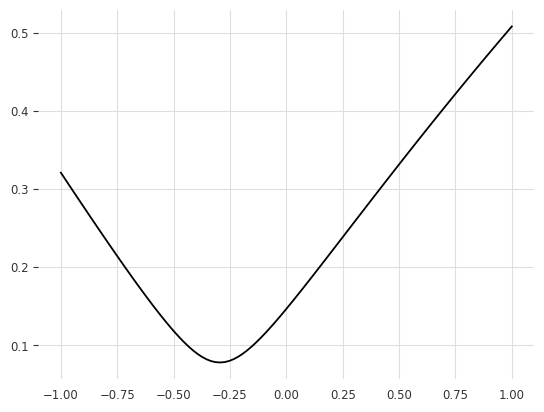

In [ ]:
l_cand = np.linspace(-1, 1, 100)
guerreros = [cv_boxcox(l) for l in l_cand]
plt.plot(l_cand, guerreros)

That's a nice plot, isn't it? There's a clear minimum, which is the the value we got at the top when we use SkTime to apply a BoxCox transformation:

In [ ]:
transformer.lambda_, cv_boxcox(transformer.lambda_)

(-0.2947236481659704, 0.07802083436563617)

In SkTime, the method is implemented in the protected function `_guerrero()`:

In [ ]:
from sktime.transformations.series.boxcox import _guerrero
_guerrero(y, 12)

-0.2947236481659704

The inverse transformation uses SciPy's `inv_boxcox()` function:

In [ ]:
import scipy
scipy.special.inv_boxcox(y_hat, _guerrero(y, 12)), y

(Period
 1949-01    112.0
 1949-02    118.0
 1949-03    132.0
 1949-04    129.0
 1949-05    121.0
            ...  
 1960-08    606.0
 1960-09    508.0
 1960-10    461.0
 1960-11    390.0
 1960-12    432.0
 Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64,
 Period
 1949-01    112.0
 1949-02    118.0
 1949-03    132.0
 1949-04    129.0
 1949-05    121.0
            ...  
 1960-08    606.0
 1960-09    508.0
 1960-10    461.0
 1960-11    390.0
 1960-12    432.0
 Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64)

## Loess

LOESS (Locally Estimated Scatterplot Smoothing) is a non-parametric way of smoothing a time series. It bears resemblance to another non-parametric method, K-Nearest Neighbors, when it comes to subsetting the data.

In LOESS, the data points are sorted (which is straightforward when talking about dates), and the nearest neighbors (a fraction of all data points) are selected to fit a (local) linear (weighted) regression on that subset of the data. Each neighbor receives a weight: closer neighbors get higher weights.

Let's work through an example:

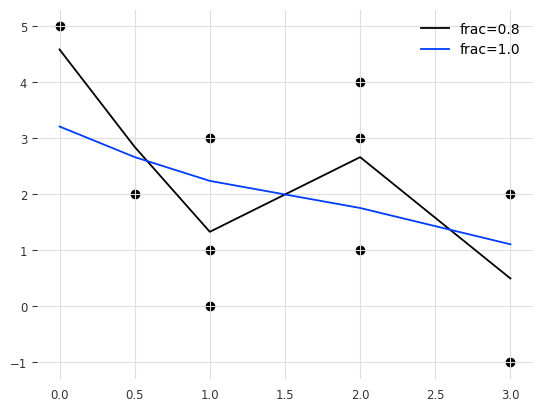

In [ ]:
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

lowess = sm.nonparametric.lowess

y = np.array([5, 3, 4, 2, 3, 1, 2, 0, 1, -1])
x = np.array([0, 1, 2, 3, 2, 1, 0.5, 1, 2, 3])

### it=0 is the basic implementation to match hand-made algos
z1 = lowess(y, x, frac=.8, it=0)
z2 = lowess(y, x, frac=1., it=0)

plt.scatter(x, y)
plt.plot(z1[:, 0], z1[:, 1], label='frac=0.8')
plt.plot(z2[:, 0], z2[:, 1], label='frac=1.0')
plt.legend()

We have 10 data points in our dummy series. If the fraction is 1.0, we're considering the full dataset for every estimate we make, resulting in a smoother line. If we reduce the fraction, fewer neighbors are considered, thus resulting in a more jagged line overall.

Let's compute LOESS for the 7th data point using a fraction of 0.8. First, we compute its distance from every other data point, and sort them, so we know which points are closer to it:

In [ ]:
our_x = x[6]
distance = abs(x - our_x)
sorted_dist = np.sort(distance)
ind = np.argsort(distance)
our_x, x, distance, ind

(0.5,
 array([0. , 1. , 2. , 3. , 2. , 1. , 0.5, 1. , 2. , 3. ]),
 array([0.5, 0.5, 1.5, 2.5, 1.5, 0.5, 0. , 0.5, 1.5, 2.5]),
 array([6, 0, 1, 5, 7, 2, 4, 8, 3, 9]))

Then, we need to decide how many neighbours we'll use given our fraction:

In [ ]:
alpha = 0.8
n = len(x)
span = int(np.ceil(alpha * n))
span

8

Next, we subset our original data to get only the close neighbors:

In [ ]:
Nx = x[ind[:span]]
Ny = y[ind[:span]]
Ndist = distance[ind[:span]]
Nx, Ny, Ndist

(array([0.5, 0. , 1. , 1. , 1. , 2. , 2. , 2. ]),
 array([2, 5, 3, 1, 0, 4, 3, 1]),
 array([0. , 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5]))

Then, we normalize the distance to the [0, 1] range, and apply the tricubic function to compute the weights:

In [ ]:
norm_dist = Ndist / max(Ndist)
weights = (1 - norm_dist**3)**3
norm_dist, weights

(array([0.        , 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        1.        , 1.        , 1.        ]),
 array([1.        , 0.89295331, 0.89295331, 0.89295331, 0.89295331,
        0.        , 0.        , 0.        ]))

We use the neighbors (which always include the initial point itself) and their weights to fit a linear regression:

In [ ]:
from sklearn.linear_model import LinearRegression

lin_loess = LinearRegression()
lin_loess.fit(Nx.reshape(-1, 1), Ny.reshape(-1, 1), sample_weight=weights)

our_x, lin_loess.predict(np.array([[our_x]]))

(0.5, array([[2.84953943]]))

As you can see, the fitted value corresponds to the original output we got at the start:

In [ ]:
z1[1, :]

array([0.5       , 2.84953943])

## Convolution

In [ ]:
# 1D conv
#https://lschmiddey.github.io/fastpages_/2021/04/30/Timeseries_Classification_with_ConvolutionalNeuralNet.html
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [ ]:
import numpy as np
from scipy import signal
sig = np.repeat([0., 1., 0.], 100)
win = signal.windows.hann(50)
filtered = signal.convolve(sig, win, mode='same') / sum(win)

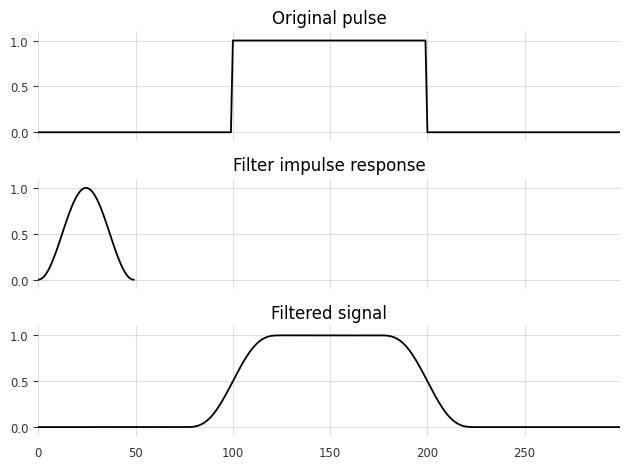

In [ ]:
import matplotlib.pyplot as plt
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()